# Análise Exploratória dos Dados (EDA)

### 1. Introdução ao RAVDESS Dataframe

#### Aqui está um exemplo de um nome de arquivo de áudio conforme descrito no site oficial do RAVDESS:
    - Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
    - Vocal channel (01 = speech, 02 = song).
    - Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
    - Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
    - Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
    - Repetition (01 = 1st repetition, 02 = 2nd repetition).
    - Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

#### Aqui está um exemplo do aúdio 02-01-06-01-02-01-12.mp4. Isso significa que os metadados para esse arquivo de áudio são:
    - Video-only (02)
    - Speech (01)
    - Fearful (06)
    - Normal intensity (01)
    - Statement "dogs" (02)
    - 1st Repetition (01)
    - 12th Actor (12) - Female (as the actor ID number is even)

### 2. Criando um DataFrame sobre os arquivos de áudio do dataset RAVDESS

#### 2.1. Importando as bibliotecas

In [53]:
import pandas as pd
import numpy as np
from scipy import stats

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#### 2.2. Criando o dataframe

In [54]:
Ravdess = "C:/Users/Larissa/trilha/miniprojetodois/miniprojeto2/Audio_Speech_Actors_01-24" # Mude para o seu path
print(os.path.exists(Ravdess))

True


In [55]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(os.path.join(Ravdess, dir))
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(os.path.join(Ravdess, dir, file))
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,neutral,C:/Users/Larissa/trilha/miniprojetodois/minipr...
1,neutral,C:/Users/Larissa/trilha/miniprojetodois/minipr...
2,neutral,C:/Users/Larissa/trilha/miniprojetodois/minipr...
3,neutral,C:/Users/Larissa/trilha/miniprojetodois/minipr...
4,calm,C:/Users/Larissa/trilha/miniprojetodois/minipr...


### 3. Limpeza dos Dados
- Agora que criamos o nosso Dataframe, precisamos nos certificar que ele está limpo de erros e pronto para os próximos passos.

#### 3.1. Verificando se há arquivos corrompidos, muito curtos ou com problemas de leitura

In [56]:
def check_audio_files(df):
    valid_files = []
    invalid_files = []

    for path in Ravdess_df['Path']:
        try:
            y, sr = librosa.load(path, sr=None) 
            duration = librosa.get_duration(y=y, sr=sr) # y = sinal de audio e sr = taxa de amostragem (quantas amostras de sinal por segundo p criar um sinal, medido em Hz)
            if duration > 1:
                valid_files.append(path)
            else:
                invalid_files.append(path)
        except:
            invalid_files.append(path)

    return valid_files, invalid_files

# Verificar os arquivos do dataset
valid_files, invalid_files = check_audio_files(Ravdess_df)

# Filtrar o DataFrame para manter apenas os arquivos válidos
Ravdess_df = Ravdess_df[Ravdess_df["Path"].isin(valid_files)]

print(f"Arquivos válidos: {len(valid_files)}")
print(f"Arquivos inválidos: {len(invalid_files)}")

Arquivos válidos: 1440
Arquivos inválidos: 0


### 4. Exploração e Visualização dos Dados

#### 4.1. Visualizando quais são as principais emoções presentes em nosso dataframe

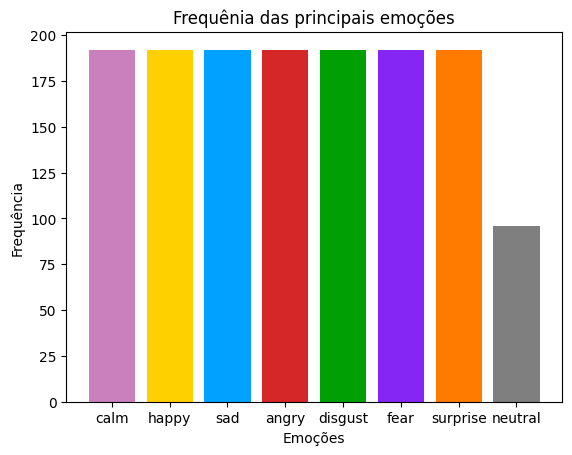

In [57]:
# Plote um gráfico mostrando as principais emoções do dataframe
# Code here
emocoes = Ravdess_df['Emotions'].value_counts()
colors = ["#ca80bd", "#ffd000", "#01a2ff", '#d62728', 
          "#009f03", "#8626f4", "#ff7b00", '#7f7f7f']
plt.bar(emocoes.index, emocoes.values, color=colors)
plt.title("Frequênia das principais emoções")
plt.xlabel("Emoções")
plt.ylabel("Frequência")
plt.show()

#### 4.2. Plotando o sinal de aúdio em forma de onda e em espectograma
- Forma de Onda - Os Waveplots nos permitem visualizar a intensidade (volume) do áudio em um determinado momento.
- Espectrogramas - Um espectrograma é uma representação visual do espectro de frequências de um som ou de outros sinais à medida que variam ao longo do tempo. Ele mostra como as frequências mudam em relação ao tempo para um determinado sinal de áudio.

In [58]:
Ravdess_df['Emotions'].unique()

array(['neutral', 'calm', 'happy', 'sad', 'angry', 'fear', 'disgust',
       'surprise'], dtype=object)

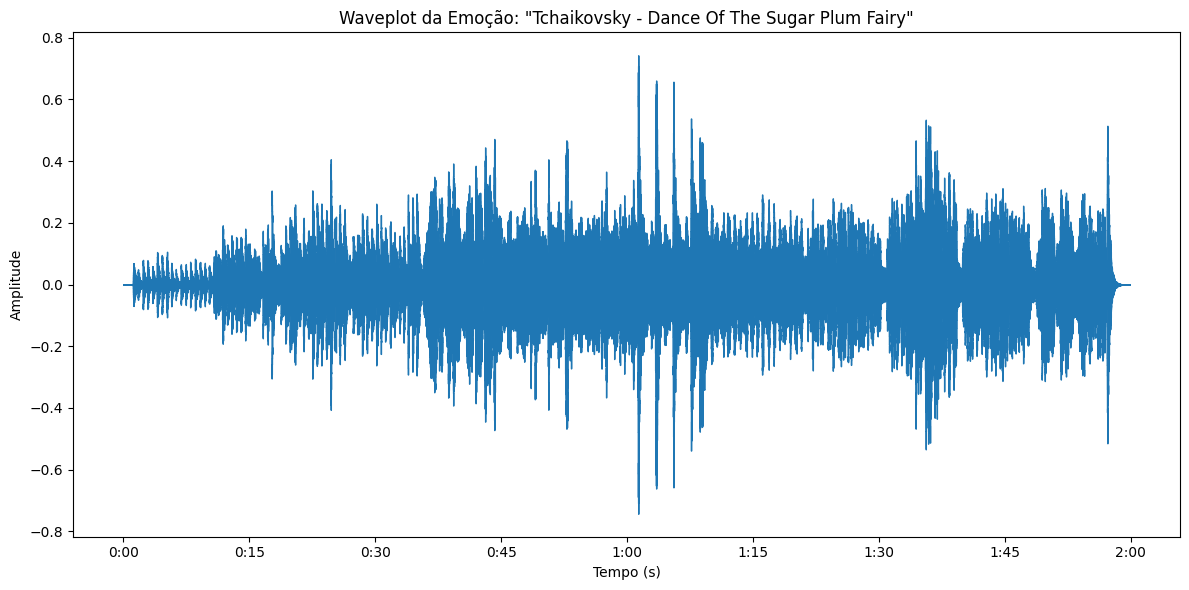

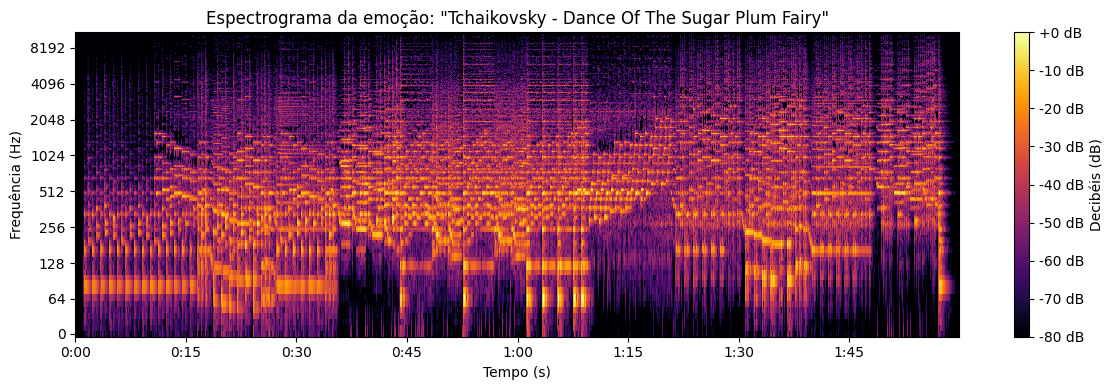

In [59]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(12, 6))
    plt.title(f'Waveplot da Emoção: {e.title()}')
    librosa.display.waveshow(y=data, sr=sr)
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

def create_spectrogram(data, sr, e):
    stft = librosa.stft(data)
    espectrograma = np.abs(stft)
    espectrograma_db = librosa.amplitude_to_db(espectrograma, ref=np.max) 
    
    plt.figure(figsize=(12, 4))
    img = librosa.display.specshow(espectrograma_db, sr=sr, x_axis='time', y_axis='log', cmap='inferno')

    plt.title(f'Espectrograma da emoção: {e.title()}')
    plt.colorbar(img, format='%+2.0f dB', label='Decibéis (dB)')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Frequência (Hz)')
    plt.tight_layout()
    plt.show()

audio_path = librosa.ex('nutcracker')
data, sample_rate = librosa.load(audio_path)
emocao_exemplo = '"Tchaikovsky - Dance of the Sugar Plum Fairy"'

create_waveplot(data, sample_rate, emocao_exemplo)
create_spectrogram(data, sample_rate, emocao_exemplo)
 


#### Agora rode as células abaixo para ver os resultados do que você fez :)

#### Emoção de Medo

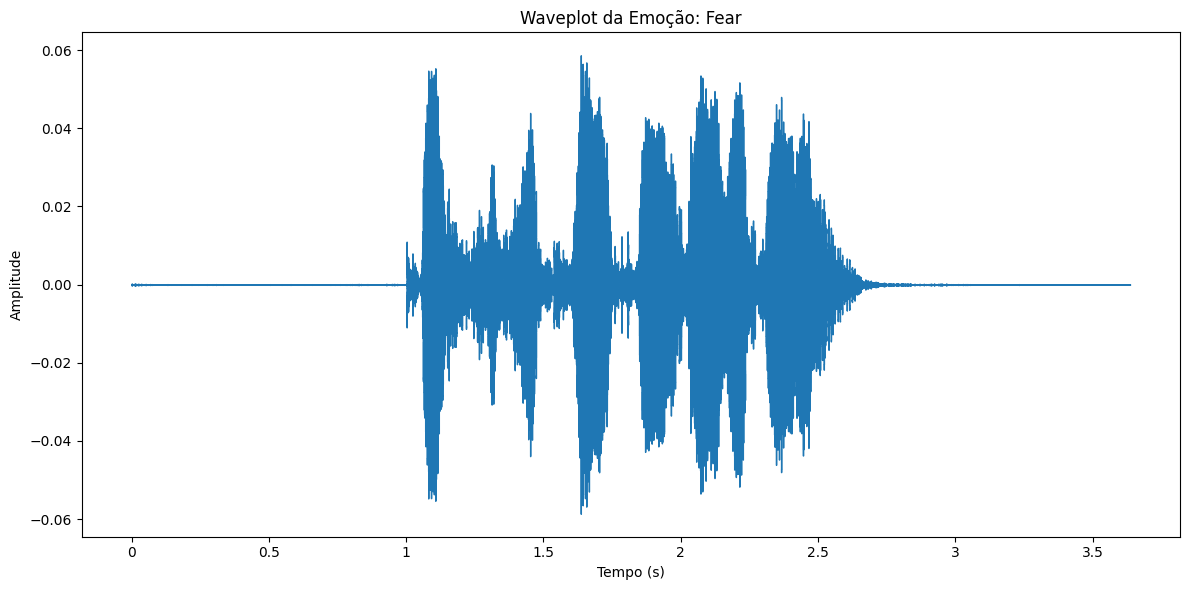

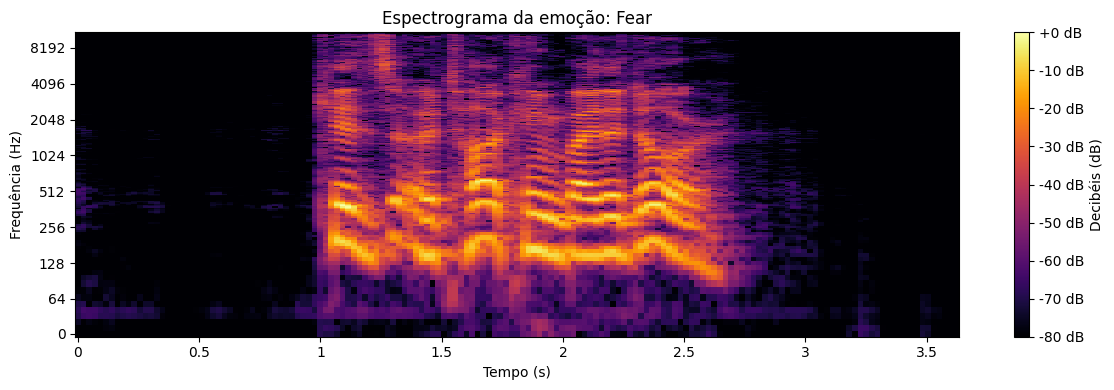

In [60]:
emotion='fear'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

#### Emoção de felicidade

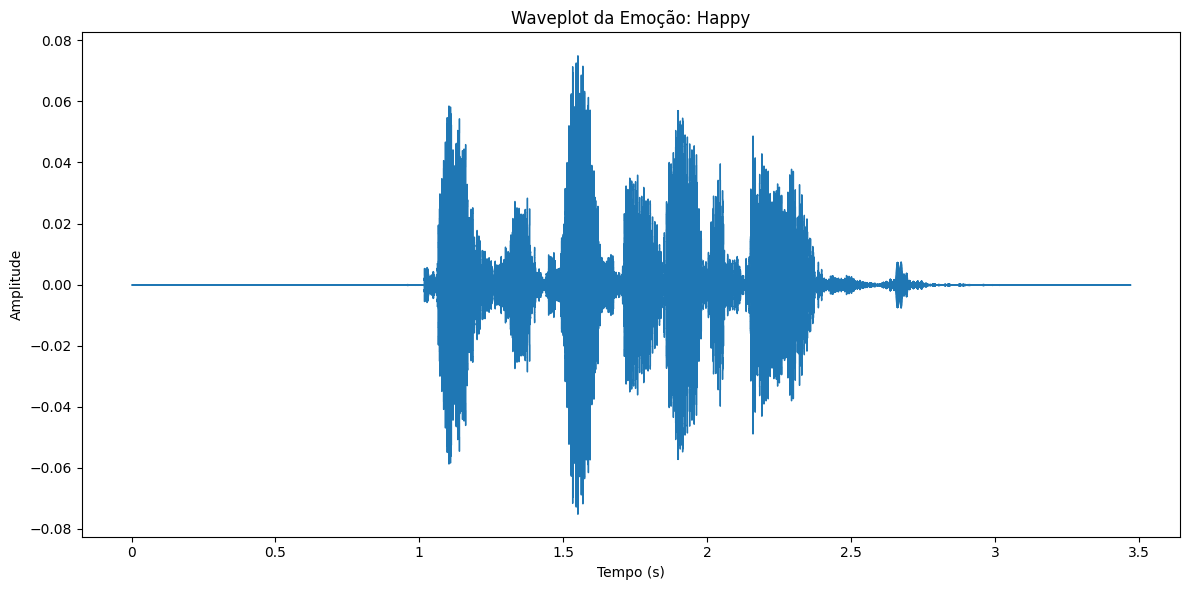

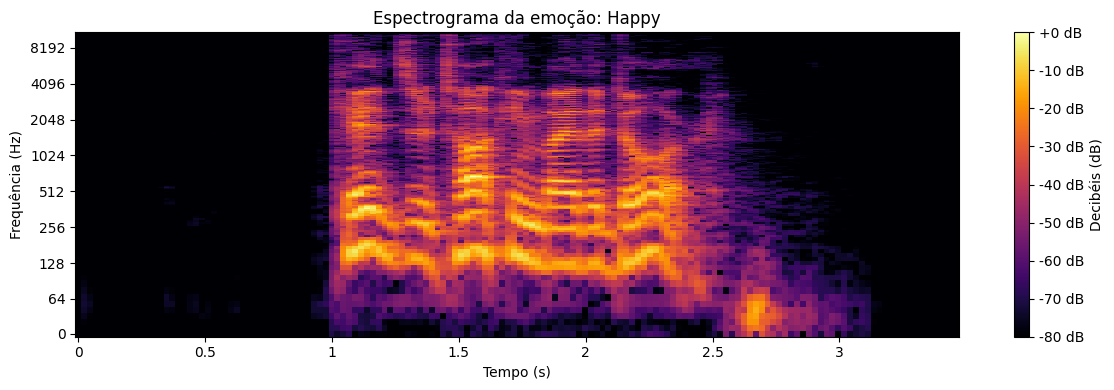

In [61]:
emotion='happy'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

#### 4.3. Analisar a duração dos áudios


Estatísticas das Durações: 
Duração mínima: 2.00 segundos
Duração máxima: 5.27 segundos
Duração média: 3.70 segundos
Mediana das durações: 3.67 segundos
Moda das durações: 3.50 segundos


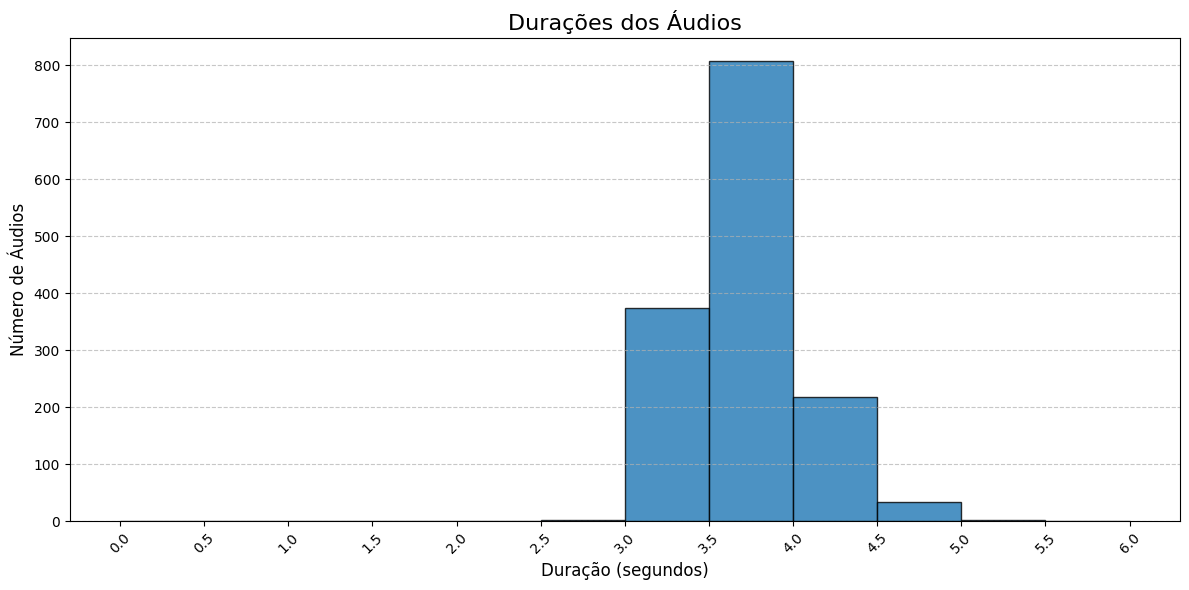

In [62]:
# Plote um histograma para ver como está a distribuição da duração dos aúdios no dataset
# Code here
pasta_principal = 'C:/Users/Larissa/trilha/miniprojetodois/miniprojeto2/Audio_Speech_Actors_01-24'

lista_duracoes = []

for root, dirs, files in os.walk(pasta_principal):
    for filename in files:
        caminho_completo = os.path.join(root, filename)
            
        duracao = librosa.get_duration(path=caminho_completo)
        lista_duracoes.append(duracao)

duracoes_array = np.array(lista_duracoes)

print("\nEstatísticas das Durações: ")
print(f"Duração mínima: {duracoes_array.min():.2f} segundos")
print(f"Duração máxima: {duracoes_array.max():.2f} segundos")
print(f"Duração média: {duracoes_array.mean():.2f} segundos")
print(f"Mediana das durações: {np.median(duracoes_array):.2f} segundos")
print(f"Moda das durações: {stats.mode(duracoes_array, keepdims=True).mode[0]:.2f} segundos")
    
plt.figure(figsize=(12, 6))

limite_superior = np.ceil(duracoes_array.max()) 
intervalo = 0.5 
bins = np.arange(0, limite_superior + intervalo, intervalo)

plt.hist(duracoes_array, bins=bins, edgecolor='black', alpha=0.8)
plt.title('Durações dos Áudios', fontsize=16)
plt.xlabel('Duração (segundos)', fontsize=12)
plt.ylabel('Número de Áudios', fontsize=12)
plt.xticks(bins) 
plt.xticks(rotation=45) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() 
plt.show()



### 5. Aumento de Dados (Data Augmentation)
- O aumento de dados é o processo pelo qual criamos novas amostras sintéticas de dados adicionando pequenas perturbações ao nosso conjunto de treinamento original.
- Para gerar dados sintéticos para áudio, podemos aplicar injeção de ruído, deslocamento no tempo, alteração de tom (pitch) e velocidade.
- O objetivo é tornar nosso modelo invariante a essas perturbações e melhorar sua capacidade de generalização.
- Para que isso funcione, as perturbações adicionadas devem manter o mesmo rótulo da amostra de treinamento original.
- No caso de imagens, o aumento de dados pode ser realizado por meio de deslocamento, zoom, rotação, entre outras técnicas.

Agora, vamos verificar quais técnicas de aumento de dados funcionam melhor para o nosso conjunto de dados :)

In [ ]:
def noise(data):
   
    noise_amp = 0.035 * np.random.uniform() * np.max(data)
    
    data += noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5000, high=5000))
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, n_steps=4):

    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=n_steps)

#### 5.1. Simple Audio

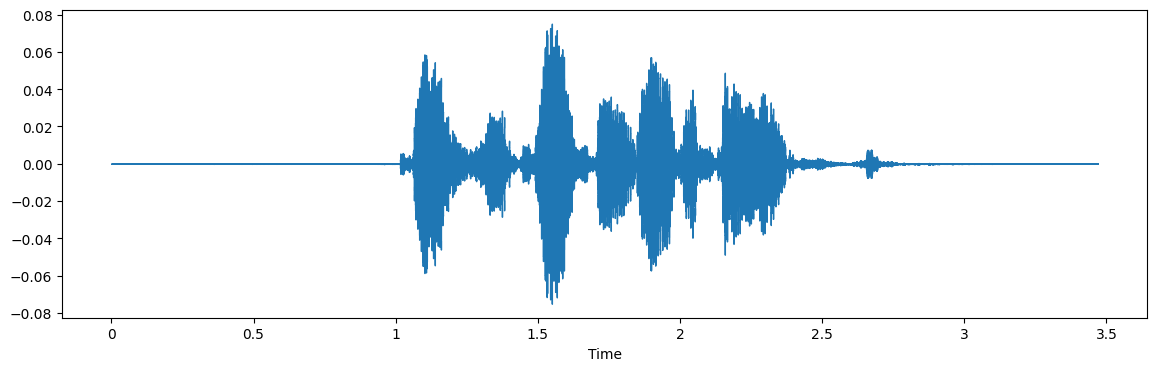

In [64]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 5.2. Noise Injection (Injeção de ruído)

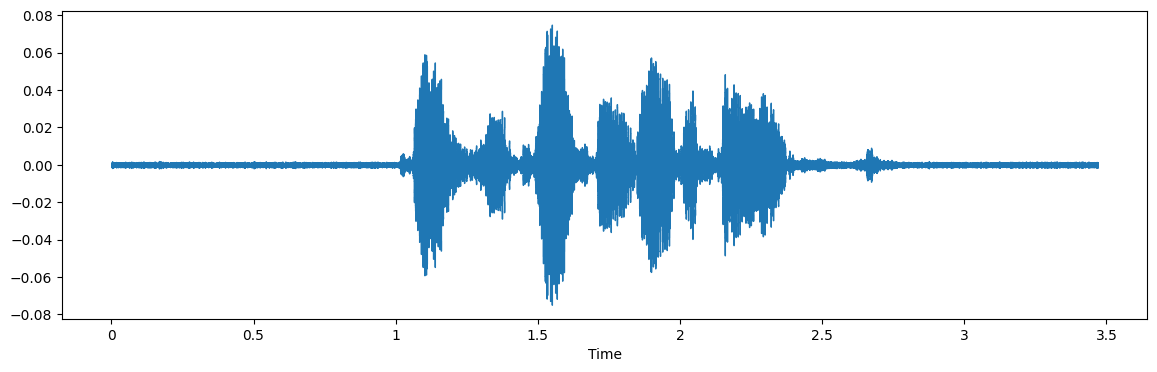

In [65]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5.3. Stretching (Alongamento)
- Mudando a velocidade do aúdio

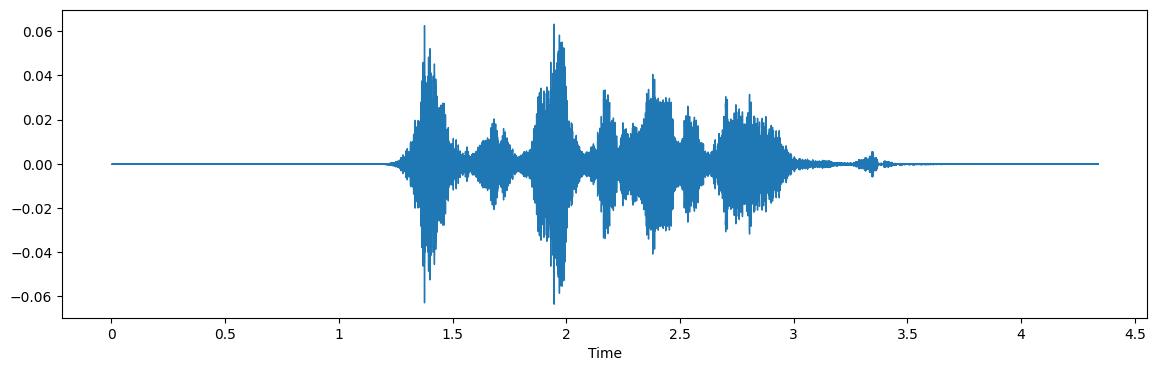

In [66]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5.4. Shifting (Deslocamento)
- Estou deslocando o sinal de áudio no tempo

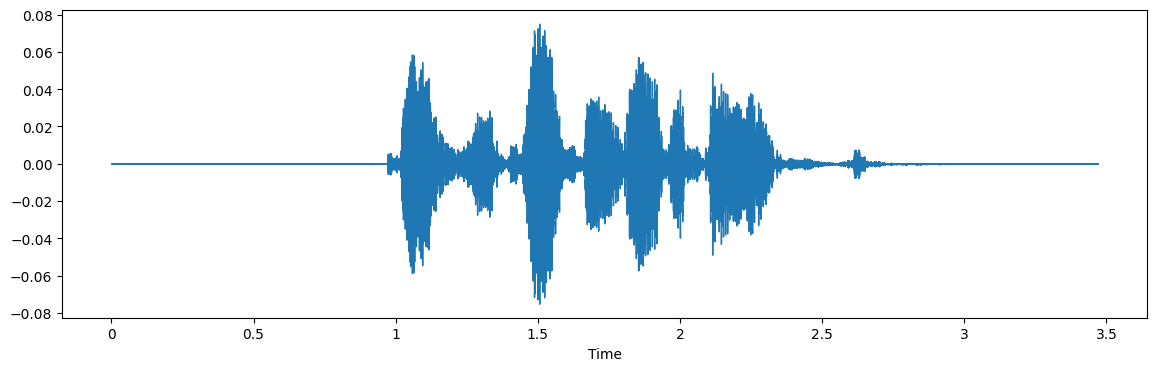

In [67]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5.5. Pitch (Tom)

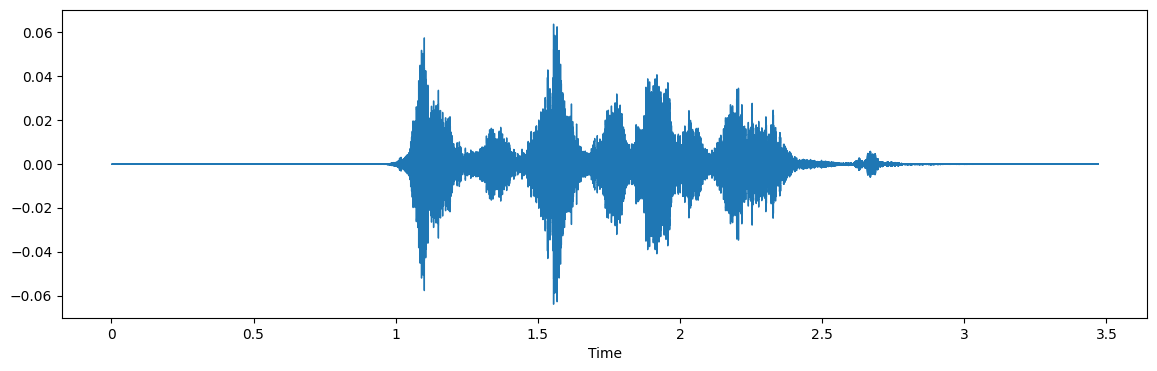

In [68]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### 6. Preparando o dataframe para a extração das features

#### 6.1. Função para Padronizar Áudios

In [ ]:
import librosa
import soundfile as sf
import os
import numpy as np

def preprocess_and_save_audio(input_path, output_dir, target_sr=16000):
    """
    Padroniza e salva os arquivos de áudio.
    
    Args:
    - input_path (str): Caminho do arquivo de entrada.
    - output_dir (str): Diretório para salvar o arquivo processado.
    - target_sr (int): Taxa de amostragem desejada (default: 16000).
    
    Retorna:
    - str: Caminho do arquivo processado.
    """
    os.makedirs(output_dir, exist_ok=True) # cria um diretório de nome output_dir (e evita ter erros caso já exista)
    try:
        audio, sr = librosa.load(input_path, sr=target_sr, mono=True)
        file_name = os.path.basename(input_path) # pega so o nome do arquivo de um path
        output_path = os.path.join(output_dir, file_name) # combina o diretorio c o nome do arquivo de audio
        sf.write(output_path, audio, target_sr) # salva o audio no output path e da a nova taxa de amostragem desse arquivo
        return output_path # retorna onde o audio foi salvo
    except Exception as e:
        print("Erro ao processar")
        return None
    
# testee

teste_sr = 22050
teste_audio = np.random.randn(teste_sr * 2)
teste_input_file = "C:/Users/Larissa/trilha/miniprojetodois/miniprojeto2/Audio_Speech_Actors_01-24/Actor_05/03-01-01-01-01-01-05.wav"
sf.write(teste_input_file, teste_audio, teste_sr)

output_directory = "audios_processados" 

processed_file_path = preprocess_and_save_audio(teste_input_file, output_directory)

if processed_file_path:
    print(f"Arquivo de entrada: {teste_input_file}")
    print(f"O arquivo processado e salvo no diretório: {processed_file_path}")
    new_audio, new_sr = librosa.load(processed_file_path)
    print(f"Nova taxa de amostragem: {new_sr} Hz")

Arquivo de entrada: C:/Users/Larissa/trilha/miniprojetodois/miniprojeto2/Audio_Speech_Actors_01-24/Actor_05/03-01-01-01-01-01-05.wav
Arquivo processado e salvo em: audios_processados\03-01-01-01-01-01-05.wav
Nova taxa de amostragem: 22050 Hz


#### 6.2. Aplicar a Padronização a Todos os Áudios

In [70]:
# Definir o caminho correto para salvar os áudios processados na pasta 'data' na raiz do projeto
processed_audio_dir = os.path.join(os.path.dirname(os.getcwd()), "data", "processed_audio")

# Criar o diretório se não existir
os.makedirs(processed_audio_dir, exist_ok=True)

print(f"Os arquivos serão salvos em: {processed_audio_dir}")


# Processar todos os áudios e salvar os novos caminhos
Ravdess_df["Processed_Path"] = Ravdess_df["Path"].apply(
    lambda x: preprocess_and_save_audio(x, processed_audio_dir)
)

# Remover arquivos que falharam no processamento
Ravdess_df = Ravdess_df[Ravdess_df["Processed_Path"].notnull()]

Os arquivos serão salvos em: c:\Users\Larissa\trilha\miniprojetodois\miniprojeto2\data\processed_audio


#### 6.3. Salvar o DataFrame Final

In [71]:
# Garantir que a pasta 'data' exista 
data_dir = os.path.join(os.path.dirname(os.getcwd()), "data")
os.makedirs(data_dir, exist_ok=True)

# Caminho correto para salvar o CSV na pasta 'data'
csv_path = os.path.join(data_dir, "ravdess_preprocessed.csv")

# Salvar o DataFrame no local correto, usa a função to_csv do pandas :)
# Code here

print(f"O arquivo foi salvo em: {csv_path}")

O arquivo foi salvo em: c:\Users\Larissa\trilha\miniprojetodois\miniprojeto2\data\ravdess_preprocessed.csv


### Isso é tudo por aqui, você fez um ótimo trabalho e está indo muito bem!
#### Estamos prontos para o pŕoximo notebook, mas antes vamos ver as coisas que aprendemos até então:
- Criamos o dataframe (você mudou o path e entendeu a cara do nosso dataframe)
- Limpamos os dados (verificamos se existiam aúdios corrompidos)
- Plotamos gráficos (fizemos uns gráficos bem bonitos sobre o dataframe)
- Data augmentation (aplicamos algumas funções no aúdio para aumentar a quantidade de dados)
- Salvamos um dataframe com pandas (usamos to_csv)